# Today
- decide if we want to inspect sentences from training
- for ovv remove from list of words in training and test also words from glove, other than the ones in training
- can we split compound terms?

# Assignment 1

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: POS tagging, Sequence labelling, RNNs

# [Task 1 - 0.5 points] Corpus

You are going to work with the [Penn TreeBank corpus](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip).

**Ignore** the numeric value in the third column, use **only** the words/symbols and their POS label.

### Example

```Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8
```

### Splits

The corpus contains 200 documents.

   * **Train**: Documents 1-100
   * **Validation**: Documents 101-150
   * **Test**: Documents 151-199
### Instructions

* **Download** the corpus.
* **Encode** the corpus into a pandas.DataFrame object.
* **Split** it in training, validation, and test sets.

# [Task 2 - 0.5 points] Text encoding

To train a neural POS tagger, you first need to encode text into numerical format.
### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.
* [Optional] You are free to experiment with text pre-processing: **make sure you do not delete any token!**

# [Task 3 - 1.0 points] Model definition

You are now tasked to define your neural POS tagger.
### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

* **Do not mix Model 1 and Model 2**. Each model has its own instructions.

**Note**: if a document contains many tokens, you are **free** to split them into chunks or sentences to define your mini-batches.

# [Task 4 - 1.0 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using macro F1-score, compute over **all** tokens.
* **Concatenate** all tokens in a data split to compute the F1-score. (**Hint**: accumulate FP, TP, FN, TN iteratively)
* **Do not consider punctuation and symbol classes** $\rightarrow$ [What is punctuation?](https://en.wikipedia.org/wiki/English_punctuation)

**Note**: What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)
### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!


# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline, Model 1, and Model 2.
### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

# [Task 6 - 1.0 points] Error Analysis

You are tasked to evaluate your best performing model.

### Instructions

* Compare the errors made on the validation and test sets.
* Aggregate model errors into categories (if possible)
* Comment the about errors and propose possible solutions on how to address them.

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).
### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Punctuation

**Do not** remove punctuation from documents since it may be helpful to the model.

You should **ignore** it during metrics computation.

If you are curious, you can run additional experiments to verify the impact of removing punctuation.

In [1]:
import sys
import shutil
import urllib
import os

import warnings
warnings.filterwarnings("ignore")

import zipfile
from pathlib import Path
import requests

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Iterable, List, Callable, Dict
from tqdm import tqdm
import random
import numpy as np
import tensorflow as tf

seed = 812

tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

tf.config.experimental.enable_op_determinism()
# Set environment variable for TensorFlow
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [2]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_dataset(download_path: Path, url: str):
    response = requests.get(url)
    with open(download_path, 'wb') as f:
        f.write(response.content)

def download_url(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")

def extract_dataset(download_path: Path, extract_path: Path):
    print("Extracting dataset... (it may take a while...)")
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction completed!")

In [3]:
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
dataset_name = "dependency_treebank"

print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_zip_path = dataset_folder.joinpath("dependency_treebank.zip")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_zip_path.exists():
    download_dataset(dataset_zip_path, url)

if not dataset_path.exists():
    extract_dataset(dataset_zip_path, dataset_folder)

Current work directory: d:\università\Magistrale\NLP\Assignement\Assignment1NLP


In [4]:
folder = dataset_folder.joinpath(dataset_name)

In [5]:
#Corpus splitted by sentence
dataframe_rows = []
index = 0
tag_set = set([])
for file_path in folder.glob('*.dp'):
    with file_path.open(mode='r', encoding='utf-8') as text_file:
        index+=1
        sentence =  ''
        tag = []
        lines = text_file.readlines()
        for line in lines:
            line_parts = line.split('\t')
            if len(line_parts) == 1: #case '\n'
                dataframe_row = {
                    "sentence": sentence,
                    "POS": tag,
                    "index": index,
                    "split": 'train' if index <=100 else  'validation' if index<=150 else 'test'
                }
                dataframe_rows.append(dataframe_row)
                sentence =  ''
                tag = []
            else:
                sentence += line_parts[0] + " "
                tag.append(line_parts[1])
                tag_set.add(line_parts[1])
        # Last sentence
        dataframe_row = {
                    "sentence": sentence,
                    "POS": tag,
                    "index": index,
                    "split": 'train' if index <=100 else  'validation' if index<=150 else 'test'
                }
        dataframe_rows.append(dataframe_row)
df = pd.DataFrame(dataframe_rows)

In [6]:
"""#Corpus splitted by file
dataframe_rows = []
for file_path in folder.glob('*.dp'):
    file_sentences =  [] 
    tag = []
    with file_path.open(mode='r', encoding='utf-8') as text_file:
        lines = text_file.readlines()
        for line in lines:
            line_parts = line.split('\t')
            if len(line_parts) != 1: #case '\n'
                file_sentences.append(line_parts[0])
                tag.append(line_parts[1])
        # Last sentence
        dataframe_row = {
                    "sentence": file_sentences,
                    "POS": tag,
                }
        dataframe_rows.append(dataframe_row)
        
df_file = pd.DataFrame(dataframe_rows)"""

In [7]:
"""df_file"""

,sentence,POS
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
2,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
3,"[Yields, on, money-market, mutual, funds, cont...","[NNS, IN, JJ, JJ, NNS, VBD, TO, VB, ,, IN, NNS..."
4,"[J.P., Bolduc, ,, vice, chairman, of, W.R., Gr...","[NNP, NNP, ,, NN, NN, IN, NNP, NNP, CC, NNP, ,..."
...,...,...
194,"[John, F., Barrett, ,, 40, ,, formerly, execut...","[NNP, NNP, NNP, ,, CD, ,, RB, JJ, NN, NN, CC, ..."
195,"[Leon, J., Level, ,, vice, president, and, chi...","[NNP, NNP, NNP, ,, NN, NN, CC, NN, JJ, NN, IN,..."
196,"[David, A., DiLoreto, ,, president, of, metal,...","[NNP, NNP, NNP, ,, NN, IN, NN, NN, NN, ,, VBD,..."
197,"[Two, leading, constitutional-law, experts, sa...","[CD, VBG, NN, NNS, VBD, NNP, NNP, VBZ, RB, VB,..."


In [8]:
df

,sentence,POS,index,split
0,"Pierre Vinken , 61 years old , will join the b...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",1,train
1,"Mr. Vinken is chairman of Elsevier N.V. , the ...","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",1,train
2,"Rudolph Agnew , 55 years old and former chairm...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",2,train
3,A form of asbestos once used to make Kent ciga...,"[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",3,train
4,"The asbestos fiber , crocidolite , is unusuall...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",3,train
...,...,...,...,...
3909,They also said that more than a dozen presiden...,"[PRP, RB, VBD, IN, JJR, IN, DT, NN, NNS, VBP, ...",198,test
3910,Sen. Kennedy said in a separate statement that...,"[NNP, NNP, VBD, IN, DT, JJ, NN, IN, PRP, VBZ, ...",198,test
3911,Trinity Industries Inc. said it reached a prel...,"[NNP, NNPS, NNP, VBD, PRP, VBD, DT, JJ, NN, TO...",199,test
3912,Terms were n't disclosed .,"[NNS, VBD, RB, VBN, .]",199,test


Length of longest sentence: 1265
Amount of sentences: 3914


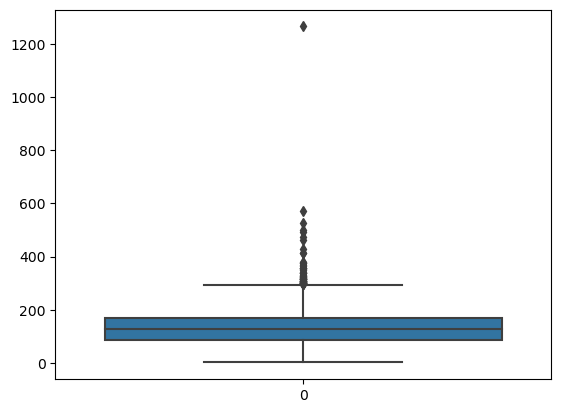

In [9]:
# check length of longest sentence
lengths = [len(seq) for seq in df['sentence']]
print("Length of longest sentence: {}".format(max(lengths)))
print("Amount of sentences: {}".format((len(lengths))))
sns.boxplot(lengths)
plt.show()

Length of longest sentence: 4534
Amount of sentences: 199


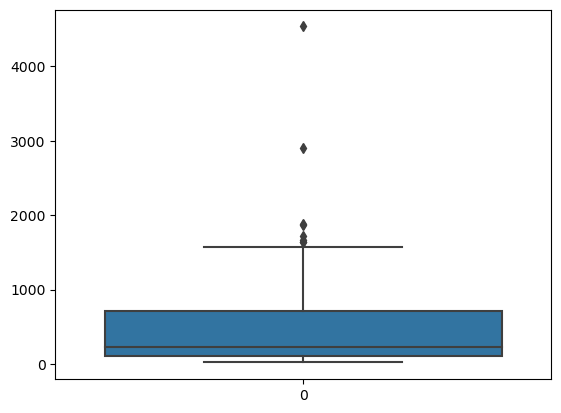

In [10]:
#df_file
lengths_file = [len(seq) for seq in df_file['sentence']]
print("Length of longest sentence: {}".format(max(lengths_file)))
print("Amount of sentences: {}".format((len(lengths_file))))
sns.boxplot(lengths_file)
plt.show()

In [11]:
#This is just an example to compute the lengths of sentences [delete] 
np_len = np.array(lengths)
print(np_len.shape)
phrases = [seq for seq in df['sentence']]
print(len(phrases))
positions = np_len > 600
print(positions)

looooong_sentences = []
for i in range(np_len.shape[0]):
    if positions[i]:
        looooong_sentences.append(phrases[i])
print(looooong_sentences)

for i in range(len(phrases)):
    if phrases[i] == looooong_sentences[0]:
        print(i)

(3914,)
3914
[False False False ... False False False]
['The following were barred or , where noted , suspended and consented to findings without admitting or denying wrongdoing : Edward L. Cole , Jackson , Miss. , $ 10,000 fine ; Rita Rae Cross , Denver , $ 2,500 fine and 30-day suspension ; Thomas Richard Meinders , Colorado Springs , Colo. , $ 2,000 fine , five-day suspension and eight-month suspension as a principal ; Ronald A. Cutrer , Baton Rouge , La. , $ 15,000 fine and one-month suspension ; Karl Grant Hale , Midvale , Utah , $ 15,000 fine ; Clinton P. Hayne , New Orleans , $ 7,500 fine and one-week suspension ; Richard M. Kane , Coconut Creek , Fla. , $ 250,000 fine ; John B. Merrick , Aurora , Colo. , $ 1,000 fine and 10-day suspension ; John P. Miller , Baton Rouge , $ 2,000 fine and two-week suspension ; Randolph K. Pace , New York , $ 10,000 fine and 90-day suspension ; Brian D. Pitcher , New Providence , N.J. , $ 30,000 fine ; Wayne A. Russo , Bridgeville , Pa. , $ 4,000

In [12]:
#Dictionary for labels
treebank_index_to_tag = {}
treebank_tag_to_index = {}
index = 1
for tag in tag_set:
    treebank_index_to_tag[index] = tag
    treebank_tag_to_index[tag] = index
    index+=1

treebank_index_to_tag[0] = ' '
treebank_tag_to_index[' '] = 0

print(treebank_index_to_tag)
print(treebank_tag_to_index)

{1: 'VBD', 2: 'CC', 3: 'IN', 4: 'WP', 5: ',', 6: 'JJS', 7: 'JJR', 8: 'NN', 9: '``', 10: 'RB', 11: 'RBS', 12: 'CD', 13: 'PRP$', 14: 'VBP', 15: 'WP$', 16: 'MD', 17: '-LRB-', 18: 'VBZ', 19: 'VBG', 20: 'PRP', 21: 'WDT', 22: "''", 23: 'SYM', 24: 'NNPS', 25: 'FW', 26: 'JJ', 27: 'NNP', 28: 'VBN', 29: 'LS', 30: '#', 31: 'DT', 32: '-RRB-', 33: 'NNS', 34: ':', 35: 'RBR', 36: 'RP', 37: 'VB', 38: 'PDT', 39: '$', 40: '.', 41: 'POS', 42: 'UH', 43: 'EX', 44: 'TO', 45: 'WRB', 0: ' '}
{'VBD': 1, 'CC': 2, 'IN': 3, 'WP': 4, ',': 5, 'JJS': 6, 'JJR': 7, 'NN': 8, '``': 9, 'RB': 10, 'RBS': 11, 'CD': 12, 'PRP$': 13, 'VBP': 14, 'WP$': 15, 'MD': 16, '-LRB-': 17, 'VBZ': 18, 'VBG': 19, 'PRP': 20, 'WDT': 21, "''": 22, 'SYM': 23, 'NNPS': 24, 'FW': 25, 'JJ': 26, 'NNP': 27, 'VBN': 28, 'LS': 29, '#': 30, 'DT': 31, '-RRB-': 32, 'NNS': 33, ':': 34, 'RBR': 35, 'RP': 36, 'VB': 37, 'PDT': 38, '$': 39, '.': 40, 'POS': 41, 'UH': 42, 'EX': 43, 'TO': 44, 'WRB': 45, ' ': 0}


In [13]:
from functools import reduce

def lower(text: str) -> str:
    return text.lower() 

PREPROCESSING_PIPELINE = [lower]

def text_prepare(text: str, filter_methods: List[Callable[[str], str]] = None) -> str:
    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)

In [38]:
df['sentence'] = df['sentence'].apply(lambda txt: text_prepare(txt))

In [39]:
from collections import OrderedDict
def build_vocabulary(df: pd.DataFrame) -> (Dict[int, str],
                                           Dict[str, int],
                                           List[str]): # builds the vocabulary of the dataset

    idx_to_word = OrderedDict() # vocabulary index to word map
    word_to_idx = OrderedDict() # word to vocabulary index map (inverse of idx_to_word)

    curr_idx = 0
    for sentence in tqdm(df.sentence.values):
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx_to_word.values()) # set of unique terms that make up the vocabulary
    return idx_to_word, word_to_idx, word_listing

In [40]:
idx_to_word_corpus, word_to_idx_corpus, word_listing_corpus = build_vocabulary(df)
idx_to_word_train, word_to_idx_train, word_listing_train = build_vocabulary(df[df['split']=='train'])
_, _, word_listing_val_and_test = build_vocabulary(df[df['split']!='train'])

100%|██████████| 1951/1951 [00:00<00:00, 278848.47it/s]


In [41]:
words_in_train_set = set(word_listing_train)
words_in_val_and_test_set = set(word_listing_val_and_test)
oov = set(words_in_val_and_test_set).difference(words_in_train_set)

In [42]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors: 
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Glove: 50, 100, 200, 300")
        raise e
    return emb_model

In [43]:
embedding_dimension = 200
embedding_model_200 = load_embedding_model(embedding_dimension=embedding_dimension)

In [44]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors, word_listing: List[str]):
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [45]:
embedding_vocabulary = set(embedding_model_200.key_to_index.keys())
oov_terms = oov.difference(embedding_vocabulary) #words that appear only in val and test
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing_val_and_test)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

Total OOV terms: 317 (4.54%)


In [46]:
# dictionary for oov to use for static embedding
index = 0 
oov_to_index_dict = {}
index_to_oov_dict = {}
for oov in oov_terms:
    oov_to_index_dict[oov] = index
    index_to_oov_dict[index] = oov
    index+=1

In [47]:
oov_terms_train = check_OOV_terms(embedding_model_200, word_listing_train) 
oov_percentage_train = float(len(oov_terms_train)) * 100 / len(word_listing_train)
print(f"Words to embed: {len(oov_terms_train)} ({oov_percentage_train:.2f}%)")

Words to embed: 359 (4.85%)


In [48]:
new_POS_list = [[treebank_tag_to_index[tag] for tag in tags] for tags in df['POS']]

In [49]:
word_listing = list(set(word_listing_corpus) - oov_terms)
word_listing.append('UNK')
word_listing.insert(0, (' ')) 
index=0
idx_to_word = {}
word_to_idx = {}
for word in word_listing:
    idx_to_word[index] = word
    word_to_idx[word] = index
    index+=1

In [50]:
sentences = []

for sentence in df[df['split'] == 'train'].sentence:
    sentences.append(sentence)

for sentence in df[df['split'] != 'train'].sentence:
    words = sentence.split()
    modified_words = [word if word not in oov_terms else 'UNK' for word in words]
    modified_sentence = ' '.join(modified_words)
    sentences.append(modified_sentence)
print('Num of sentences: ',len(sentences))

Num of sentences:  3914


In [51]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: Dict[str,int] = None) -> np.ndarray:
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(word_to_idx.items()):
        if word == 'UNK':
            embedding_matrix[idx] = np.zeros(embedding_dimension)
        else:
            try:
                embedding_vector = embedding_model[word]
            except (KeyError, TypeError):
                embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [52]:
embedding_matrix = build_embedding_matrix(embedding_model_200, embedding_dimension, word_to_idx, len(word_to_idx))

100%|██████████| 10632/10632 [00:00<00:00, 462265.62it/s]


In [53]:
encoded_sentences = [[word_to_idx[word] for word in sentence.split()] for sentence in sentences]
padding_length = 600

In [54]:
from keras.utils import pad_sequences
padded_sentences = pad_sequences(
    encoded_sentences,
    maxlen=padding_length,
    padding='pre',
    truncating='pre',
    value=0 #this is the space
)
padded_POS = pad_sequences(
    new_POS_list,
    maxlen=padding_length,
    padding='pre',
    truncating='pre',
    value=0
)

In [55]:
from keras.utils import to_categorical
training_samples = df[df['split']=='train'].count().sentence
validation_samples = df[df['split']=='validation'].count().sentence
validation_samples+=training_samples

X_train = padded_sentences[:training_samples,:]
Y_train = to_categorical(padded_POS[:training_samples,:])
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

X_val = padded_sentences[training_samples:validation_samples,:]
Y_val = to_categorical(padded_POS[training_samples:validation_samples,:])
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

X_test = padded_sentences[validation_samples:,:]
Y_test = to_categorical(padded_POS[validation_samples:,:])
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [56]:
variables = {
    "X_train": X_train,
    "Y_train": Y_train,
    "X_val": X_val,
    "Y_val": Y_val,
    "X_test": X_test,
    "Y_test": Y_test,
    "embedding_matrix": embedding_matrix
}

for name, value in variables.items():
    print(f"{name}.shape:", value.shape)

X_train.shape: (1963, 600)
Y_train.shape: (1963, 600, 46)
X_val.shape: (1299, 600)
Y_val.shape: (1299, 600, 46)
X_test.shape: (652, 600)
Y_test.shape: (652, 600, 46)
embedding_matrix.shape: (10632, 200)


In [57]:
punctuations_indeces = [0,27,36,41,42,43]

In [58]:
from sklearn.metrics import f1_score
import keras.backend as K
def macro_f1_score(num_classes, ignore_class_indices):
    def f1(y_true, y_pred):
        f1_scores = []
        for i in range(num_classes):
            if i not in ignore_class_indices:
                true_positives = K.sum(K.cast(y_true[:, :, i] * y_pred[:, :, i], 'float32'))
                possible_positives = K.sum(K.cast(y_true[:, :, i], 'float32'))
                predicted_positives = K.sum(K.cast(y_pred[:, :, i], 'float32'))

                precision = true_positives / (predicted_positives + K.epsilon())
                recall = true_positives / (possible_positives + K.epsilon())

                f1 = 2 * (precision * recall) / (precision + recall + K.epsilon()) if (precision + recall) > K.epsilon() else 0.0
                f1_scores.append(f1)

        macro_f1 = K.mean(K.stack(f1_scores), axis=0)
        return macro_f1
    return f1

In [59]:
batch_size = 128
train = train_dataset.shuffle(buffer_size=len(X_train),seed=seed).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation = validation_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [60]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed
from keras.optimizers import Adam

baseline_model = Sequential()
baseline_model.add(Embedding(input_dim= len(word_to_idx),
                    output_dim    = 200,
                    input_length  = padding_length,
                    weights       = [embedding_matrix],
                    trainable     = True,
))   
baseline_model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
baseline_model.add(TimeDistributed(Dense(units=len(treebank_index_to_tag), activation='softmax')))
baseline_model.compile(optimizer=Adam(learning_rate=0.01),loss='categorical_crossentropy',
                   metrics=[macro_f1_score(num_classes=len(treebank_index_to_tag), ignore_class_indices=punctuations_indeces)])

In [61]:
history_model = baseline_model.fit(train, epochs=25, validation_data=validation)

Epoch 1/25
16/16 [==============================] - 67s 4s/step - loss: 0.4914 - f1: 0.0207 - val_loss: 0.1001 - val_f1: 0.0411
Epoch 2/25
 8/16 [==============>...............] - ETA: 25s - loss: 0.0887 - f1: 0.0587

In [ ]:
_ , f1_baseline = baseline_model.evaluate(test, verbose=1)

print("Loss: {0},\nMacro F1 Score: {1}".format(f1))

11/11 [==============================] - 2s 140ms/step - loss: 0.1223 - f1: 0.0229
Loss: 0.12229162454605103,
Macro F1 Score: 0.022876782342791557


In [ ]:
unit_LSTM = 128

model_1 = Sequential()
model_1.add(Embedding(input_dim     = len(word_to_idx),
                             output_dim    = embedding_dimension,
                             input_length  = padding_length,
                             weights       = [embedding_matrix],
                             trainable     = True
))
model_1.add(Bidirectional(LSTM(units = unit_LSTM, return_sequences=True)))
model_1.add(LSTM(units = unit_LSTM, return_sequences=True))
model_1.add(TimeDistributed(Dense(units=len(treebank_index_to_tag), activation='softmax')))

model_1.compile(optimizer= Adam(optimizer=Adam(learning_rate=0.01)), loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

model_1_training = model_1.fit(train, batch_size=batch_size, epochs=25, validation_data=validation)
_, f1_model_2 = model_1.evaluate(test, verbose = 1)

In [ ]:
model_2 = Sequential()
model_2.add(Embedding(input_dim     = len(word_to_idx),
                             output_dim    = embedding_dimension,
                             input_length  = padding_length,
                             weights       = [embedding_matrix],
                             trainable     = False
))
model_2.add(Bidirectional(LSTM(units = unit_LSTM, return_sequences=True)))
model_2.add(Dense(units = unit_LSTM, activation='relu'))
model_2.add(TimeDistributed(Dense(units=len(treebank_index_to_tag), activation='softmax')))

model_2.compile(optimizer= Adam(optimizer=Adam(learning_rate=0.01)), loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

model_2_training = model_2.fit(train, batch_size=batch_size, epochs=25, validation_data=validation)
_, f1_model_2 = model_2.evaluate(test, verbose = 1)

In [ ]:
from collections import Counter
def wrong_words(X,Y,model):
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=-1)
    print(y_pred_classes.shape)

    y_true_classes = np.argmax(Y, axis=-1)
    y_pred_classes_flat = y_pred_classes.flatten()

    y_true_classes_flat = y_true_classes.flatten()

    misclassified = []

    # Loop over the test set
    for i in range(len(X)):  # Loop over sentences
        for j in range(len(X[i])):  # Loop over words in a sentence
            pred = y_pred_classes[i][j]
            true = y_true_classes[i][j]

            if pred != true:
                word_index = X[i][j]
                #idx_to_word
                word = idx_to_word.get(word_index, 'UNK')  # Get the word, default to 'UNK' if not found
                true_tag = treebank_index_to_tag[true]
                pred_tag = treebank_index_to_tag[pred]
                misclassified.append((word, true_tag, pred_tag))  # (word, predicted_tag, true_tag)

    # Count occurrences of each misclassified word-tag pair
    misclassification_counter = Counter(misclassified)

    # Get the most common misclassified word-tag pairs
    most_common_misclassifications = misclassification_counter.most_common()

    # Print or process the most common misclassifications
    for (word, true_tag, pred_tag), count in most_common_misclassifications:
        print(f"Word: {word}, True Tag: {true_tag}, Predicted Tag: {pred_tag}, Frequency: {count}")
wrong_words(X_test, Y_test)

In [ ]:
# visualise training history
plt.plot(baseline_model.history['f1'])
plt.title('model accuracy')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.show()

## WordCloud (check)

In [ ]:
#!python pip install -m wordcloud

In [ ]:
wordtags = ['{}{}_{}'.format(word, true_tag, pred_tag) for (word, true_tag, pred_tag), count in most_common_misclassifications]
word_tag_frequency = Counter(word_tags)
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_tag_frequency)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()